In [11]:
import argparse
import json
import os
import random
import sys
import time
from importlib import reload
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from numpy import linalg as LA
from tqdm.auto import tqdm

mpl.rcParams['text.latex.preamble'] = r'\usepackage{times}'

plt.rcParams.update({
    "text.usetex": True,
})

cwd_path = Path.cwd()
dataset = "CIFAR10" # CIFAR10, CIFAR100, SVHN
v_type = "mingd" # mingd, rand

# Sizes
SMALL_SIZE = 14
MEDIUM_SIZE = SMALL_SIZE + 1
BIGGER_SIZE = MEDIUM_SIZE + 1
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsi ze of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE - 5)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [12]:
def cosine_similarity(A: np.ndarray, B: np.ndarray):
    # assert A.shape == B.shape
    A_dist = LA.norm(A, 2) if len(A.shape) == 1 else LA.norm(A, 2, axis=1)
    return np.dot(A, B) / (A_dist * LA.norm(B, 2))

In [13]:
cifar10_mean = np.array((0.4914, 0.4822, 0.4465))
cifar10_std = np.array((0.2471, 0.2435, 0.2616))

hdf_output_parent_dir_path = cwd_path / "hdf"
hdf_output_parent_dir_path.mkdir(exist_ok=True)
hdf_output_path = hdf_output_parent_dir_path / f"{dataset}_{v_type}.h5"

results_df = pd.read_hdf(str(hdf_output_path), v_type)

rename_dict = {  # ! Change mapping
    "threat_model": "Threat Model",
    "teacher": "Source (CIFAR10 train set)",
    # "distillation": "Distillation",
    # "extract-label": "Label-Query",
    # "extract-logit": "Logit-Query",
    # "zero-shot": "Zero-Shot Learning",
    # "fine-tune": "Fine-Tuning",
    # "pre-act-18": "Diff. Architecture",
    "independent": "Independent (CIFAR10 test set)",
    # "baseline": "Baseline",
    "rgb-grayscale_mean_-0.631_-0.97_-0.058": "gray mean -0.631 -0.97 -0.058",
    "rgb-grayscale_mean_0.365_-0.892_-0.559": "gray mean 0.365 -0.892 -0.559",
    "rgb-grayscale_mean_-0.668_-0.004_0.165": "gray mean -0.668 -0.004 0.165",
    "rgb-grayscale_mean_-0.631_-0.648_0.624": "gray mean -0.631 -0.648 0.624",
    "rgb-grayscale_mean_0.598_0.036_-0.537": "gray mean 0.598 0.036 -0.537",
    "rgb-grayscale_mean_0.78_0.026_-0.51": "gray mean 0.78 0.026 -0.51",
    "rgb-grayscale_mean_0.648_-0.572_0.483": "gray mean 0.648 -0.572 0.483",
    "rgb-grayscale_mean_0.26_0.855_-0.536": "gray mean 0.26 0.855 -0.536",
    "rgb-grayscale_mean_0.847_-0.447_0.64": "gray mean 0.847 -0.447 0.64",
    "rgb-grayscale_mean_0.456_0.837_0.251": "gray mean 0.456 0.837 0.251",
}

plot_df = (results_df.rename(columns=rename_dict).replace(rename_dict)
           .query('(m >= 5)')
           )

# ! Fix: ValueError: cannot reindex on an axis with duplicate labels
plot_df[plot_df.index.duplicated()]
plot_df.reset_index(inplace=True)


In [14]:
model_types = list(rename_dict.values())
selected_m_list = [14, 24, 34, 44]
selected_model_types = list(rename_dict.values())[3:]
selected_mean_values = []

with open('mean_values.json', 'r') as openfile:
    selected_mean_values = json.load(openfile)

cossim_p_data = {
    'm': [],
    'cossim_value': [],
    'mean_p_value': [],
}
cossim_value_list = []
for m in selected_m_list:
    for model_idx in range(len(selected_model_types)):
        threat_model = selected_model_types[model_idx]
        mean_value = selected_mean_values[model_idx]
        cossim_value = cosine_similarity(np.array(mean_value), cifar10_mean).item()
        filter_pd = plot_df[(plot_df['m'] == m) & (plot_df['Threat Model'] == threat_model)]
        mean_p_value = filter_pd['p_value'].to_numpy().mean()

        cossim_p_data['m'].append(m)
        cossim_p_data['cossim_value'].append(cossim_value)
        cossim_p_data['mean_p_value'].append(mean_p_value)
        cossim_value_list.append(cossim_value)

cossim_p_df = pd.DataFrame.from_dict(cossim_p_data)

Text(0, 0.5, 'Mean of p-value')

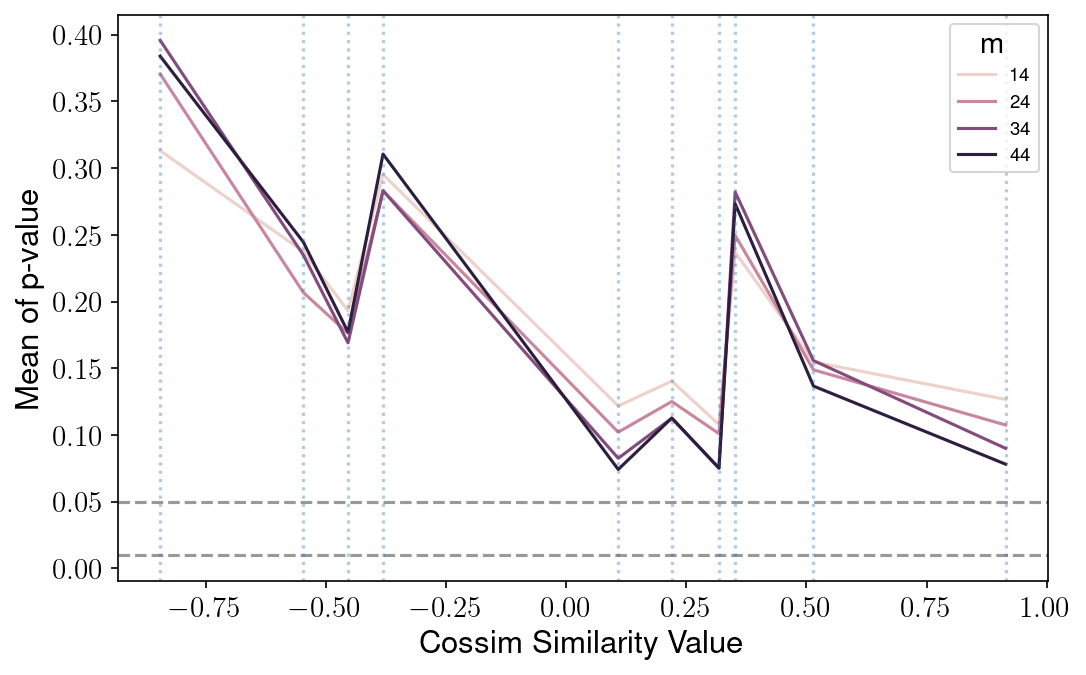

In [15]:
fig, ax = plt.subplots(figsize=(8, 5), dpi=150)
g = sns.lineplot(x="cossim_value", y="mean_p_value", hue="m", data=cossim_p_df, ax=ax, ci=99)
g.axhline(0.05, ls='--', color="black", alpha=0.4)
g.axhline(0.01, ls='--', color="black", alpha=0.4)
# g.set_xticks(np.arange(np.min(cossim_value_list), np.max(cossim_value_list), 0.01), minor=True)
for cossim_value in cossim_value_list:
    g.axvline(cossim_value, ls=':', alpha=0.1)
g.set_xlabel("Cossim Similarity Value")
g.set_ylabel("Mean of p-value")